<a target="_blank" href="https://colab.research.google.com/github/amanichopra/sap-genai-hub/blob/main/agents.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Preparation

## Install Libraries

In [35]:
!pip install "generative-ai-hub-sdk[all]"
!pip install langgraph langchain-openai
!pip install pygraphviz

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## Authentication

Before requests to orchestration can be issued, we need to provide authentication details to the SDK. This can be done either via a configuration file or via the environment. Make sure to read the [Generative AI Hub SDK docs](https://help.sap.com/doc/generative-ai-hub-sdk/CLOUD/en-US/index.html) for more details. Below you will find an example for authenticating via environment variables using this very notebook. Ensure to store credentials in a `.env` file for the below command to work.

In [135]:
import os
from dotenv import load_dotenv

load_dotenv()

True

# Agents

We will build an AI Agent that is an expert at making personalized meal plans using the Langgraph orchestration [framework](https://www.langchain.com/langgraph). Langchain is a leading framework for building LLM-based apps, by executing sequential actions, aka "chains". However, we are restricted to only created DAGs. With AI agents becoming popular, there is increased demand for interactions that involve cycles (e.g. reasoning by LLMs). Thus, Langchain released a new framework, Langgraph to allow for building cyclic graphs. We will incorporate many concepts from the previous exercises including the orchestration service from the Generative AI Hub and RAG, which was covered in the last exercise. 

We will represent an agent by a graph containining nodes, edges, and state. The nodes are functions which can be LLM calls or standard function/tool calls, the edges connect the nodes together to create chains of events, and the state is essentially the agent's memory and is accesible from every node in the graph. First, we will intialize a state.

In [93]:
from typing import TypedDict, List

class RecipeState(TypedDict):
    ingredients: List[str]
    retrieved_recipes: List[str]
    generated_recipe: str
    is_complete: bool
    user_email: str

Now, let's define our HANA DB connection. We will need this by one of the nodes to perform RAG to retrive similar meals based on the user-provided ingredient list.

In [47]:
from gen_ai_hub.proxy.langchain.openai import OpenAIEmbeddings
from langchain_community.vectorstores.hanavector import HanaDB
from hdbcli import dbapi

embedding_mod = OpenAIEmbeddings(proxy_model_name='text-embedding-3-small')

conn = dbapi.connect(
    address=os.environ.get("HANA_HOST"),
    port=os.environ.get("HANA_PORT"),
    user=os.environ.get("HANA_USER"),
    password=os.environ.get("HANA_PASSWORD"),
    autocommit=True,
    sslValidateCertificate=True,
)

db = HanaDB(
    embedding=embedding_mod, connection=conn, table_name="INGREDIENT_EMBEDDINGS"
)

Now, let's define a function which calls an LLM via the orchestration service.

In [114]:
from gen_ai_hub.orchestration.models.message import SystemMessage, UserMessage
from gen_ai_hub.orchestration.models.template import Template
from gen_ai_hub.orchestration.models.config import OrchestrationConfig
from gen_ai_hub.orchestration.service import OrchestrationService
from gen_ai_hub.orchestration.models.llm import LLM

def call_llm_via_orchestration(system_prompt, user_prompt, llm='o3-mini'):
    template = Template(
        messages=[
            SystemMessage(system_prompt),
            UserMessage(
                user_prompt,
            ),
        ]
    )
    config = OrchestrationConfig(
        llm=LLM(llm),
        filtering=None,
        template=template
    )
    orchestration_service = OrchestrationService(
        deployment_id=os.environ["AICORE_ORCH_DEPLOYMENT_ID"],
        config=config,
    )
    result = orchestration_service.run()
    return result.orchestration_result.choices[0].message.content
    

Let's now define the nodes in the agent graph. 
1. `retreive_recipes`: retrieves meals from the HANA vector DB that are similar to the user-provided ingredients.
2. `generate_recipe`: generates a recipe using an LLM based on the ingredients provided by the user and similar meals.
3. `check_ingredients`: checks if ingredients provided by the user are contained in the generated recipe.
4. `send_email`: sends an email to the user containing the final generated recipe.

In [115]:
from msgraph import GraphServiceClient
from msgraph.generated.users.item.send_mail.send_mail_post_request_body import SendMailPostRequestBody
from msgraph.generated.models.message import Message
from msgraph.generated.models.item_body import ItemBody
from msgraph.generated.models.body_type import BodyType
from msgraph.generated.models.recipient import Recipient
from msgraph.generated.models.email_address import EmailAddress
import os
from azure.identity.aio import ClientSecretCredential
from bs4 import BeautifulSoup
import asyncio

# helper function to send emails using ms graph
async def send_email_helper(recipient_email, html):
    # Process the notification data
    scopes = ['https://graph.microsoft.com/.default']

    # Multi-tenant apps can use "common",
    # single-tenant apps must use the tenant ID from the Azure portal
    tenant_id = os.environ.get('MS_TENANT_ID')

    # Values from app registration
    client_id = os.environ.get('MS_CLIENT_ID')
    client_secret = os.environ.get('MS_CLIENT_SECRET')

    # azure.identity.aio
    credential = ClientSecretCredential(
    tenant_id=tenant_id,
    client_id=client_id,
    client_secret=client_secret)

    graph_client = GraphServiceClient(credential, scopes) # type: ignore

    request_body = SendMailPostRequestBody(
    message = Message(
        subject = f"Generated Recipe",
        body = ItemBody(
            content_type = BodyType.Html,
            content = html,
        ),
        to_recipients = [
            Recipient(
                email_address = EmailAddress(
                    address = recipient_email,
                ),
            ),
        ]
    ),
    save_to_sent_items = False,
    )
    await graph_client.users.by_user_id(os.environ.get('MS_INGESTION_EMAIL')).send_mail.post(request_body)
    return True

# helper function to replace html template with llm generated content to send in email
def get_html(generated_recipe, ingr, sim_meals):
    with open("./email_template.html", "r", encoding="utf-8") as file:
            soup = BeautifulSoup(file, "html.parser")
    soup.find(id='ingr').string = ingr
    soup.find(id='sim-meals').string = sim_meals
    soup.find(id='gen-recipe').string = generated_recipe
    return str(soup)

In [137]:
# Retrieve recipes from HANA DB
def retrieve_recipes(state: RecipeState) -> RecipeState:
    print(f'Rerieving meals for ingredients: {state["ingredients"]}')
    ingredient_str = ', '.join(state['ingredients'])
    if 'is_complete' not in state: 
        similar_recipes = db.similarity_search(ingredient_str, k=10)
    else:
        similar_recipes = db.similarity_search(ingredient_str, k=20) # generate more recipes since the original retrived recipes may have not been enough
    similar_recipes = [d.page_content for d in similar_recipes]
    return {**state, "retrieved_recipes": similar_recipes}

# Generate a new recipe based on similar recipes
def generate_recipe(state: RecipeState) -> RecipeState:
    print(f"Generating recipe using retrieved recipes...")
    system_prompt = 'You are a nutrition and meal-planning expert whose job is to generate personalized recipes given a list of meals that the user has cooked in the past and a list of ingredients that should be in the generated recipe.'
    retrieve_recipes_str = '\n\n'.join(state['retrieved_recipes'])
    user_prompt = f"Generate a recipe given the following recipes that the user has generated in the past: {retrieve_recipes_str}. Here are the ingredients that the recipe should contain: {state['ingredients']}"
    llm_response = call_llm_via_orchestration(system_prompt, user_prompt)
    return {**state, "generated_recipe": llm_response}

# Check if all ingredients are present in the generated recipe
def check_ingredients(state: RecipeState) -> RecipeState:
    print(f"Checking if generated recipe contains all the user's preferred ingredients...")
    system_prompt = 'Your job is to check if the given recipe contains ingredients from the given list of ingredients. Return only a true/false answer.'
    user_prompt = f"Here is the generated recipe: {state['generated_recipe']}\nHere are the ingredients: {state['ingredients']}"
    llm_response = call_llm_via_orchestration(system_prompt, user_prompt)
    if 'true' in llm_response.lower():
        print('All ingredients in generated recipe.')
        return {**state, "is_complete": True}
    print('Generated recipe missing ingredients.')
    return {**state, "is_complete": False}

# Send the final recipe via email
async def send_email(state: RecipeState) -> RecipeState:
    print(f"Sending recipe to {state['user_email']}...")
    html = get_html(state['generated_recipe'], ', '.join(state['ingredients']), '\n\n'.join(state['retrieved_recipes']))
    await send_email_helper(state['user_email'], html)
    print(f"Email sent successfully.")
    return state

Finally, let's define the graph.

In [138]:
from langgraph.graph import StateGraph, START, END
graph = StateGraph(RecipeState)

graph.add_node("retrieve_recipes", retrieve_recipes)
graph.add_node("generate_recipe", generate_recipe)
graph.add_node("check_ingredients", check_ingredients)
graph.add_node("send_email", send_email)


# Define how nodes transition
graph.add_edge(START, "retrieve_recipes")

graph.add_edge("retrieve_recipes", "generate_recipe")
graph.add_edge("generate_recipe", "check_ingredients")

def route_based_on_check(state: RecipeState) -> str:
    if state["is_complete"]:
        return "send_email"
    else:
        return "retrieve_recipes"

graph.add_conditional_edges("check_ingredients", route_based_on_check, {
        "send_email": "send_email",
        "retrieve_recipes": "retrieve_recipes"
    })

graph.add_edge("check_ingredients", "send_email")

# After sending email, end the graph
graph.add_edge("send_email", END)

# Compile the graph
app = graph.compile()

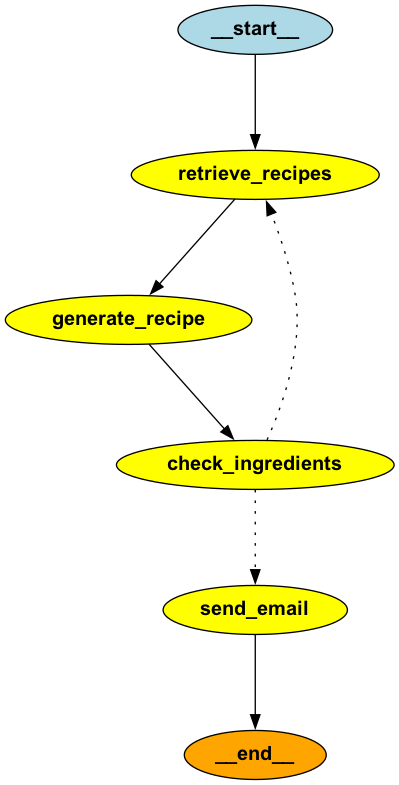

In [139]:
from IPython.display import Image
Image(app.get_graph().draw_png())

Now, let's run the agent with an example input.

In [140]:
start_state = {
    "ingredients": ["oats", "pumpkin", "chia seeds"],
    "user_email": "choppermanster@gmail.com",
}

result = await app.ainvoke(start_state)
print("\n=== Final State ===")
print(result)

Rerieving meals for ingredients: ['oats', 'pumpkin', 'chia seeds']
Generating recipe using retrieved recipes...
Checking if generated recipe contains all the user's preferred ingredients...
All ingredients in generated recipe.
Sending recipe to choppermanster@gmail.com...
Email sent successfully.

=== Final State ===
{'ingredients': ['oats', 'pumpkin', 'chia seeds'], 'retrieved_recipes': ["Ingredients:\nBob's Red Mill - Steel Cut Oats, 0.13 cup (46 grams) 85 15g 2g 4g 0mg 0mg 0g 3g\nChia seeds, 4 tsp 97 8g 6g 3g 0mg 3mg 0g 7g\nJuicy Dates - dates, 30 gram 80 18g 0g 0g 0mg 0mg 17g 3g\nTrader Joe's - Organic Unsweetened Coconut Chips,\nTrader Joe's - Raw Almond Butter - Crunchy, No Salt, 4", "Ingredients:\nBob's Red Mill - Steel Cut Oats, 0.13 cup (46 grams) 85 15g 2g 4g 0mg 0mg 0g 3g\nHemp Seed (Hemp Hearts) - Trader Joe's Raw Shelled,\nJuicy Dates - dates, 30 gram 80 18g 0g 0g 0mg 0mg 17g 3g\nKirkland - Cinamon, 2 tsp 12 4g 0g 0g 0mg 1mg 0g 3g\nPowder Vanilla Bean Flavor , 2 Scoops (51

# Summary

In this exercise, we learned how to create an AI agent using the Langgraph framework integrated with the Generative AI Hub. This completes the final exercise. Thanks for participating!